# Exercise 3: Ensemble of Batman Trees

In this exercise, we’ll revisit the Batman dataset from Exercise A. Start by splitting the data into a training of 9000 images and test set of 1000 examples each at random.

We will work with decision trees and the sklearn implementation of those.2 In this assignment we will create our own simplified version of a random forest. We will construct 100 decision trees. Train these on different subsets for each classifier, and then combine their predictions in a majority vote to use as a classifier.

The subsets should be constructed using the bootstrap technique, which in short means that we should
create new training sets for each individual decision tree in the following manner: sample 5000 training
samples with replacement from the training data (that means any sample may be chosen more than once).
This means that for instance $X_1$ is a subset of 5000 training samples, but most likely there are several which 1
are duplicates. Thus, you will create $X_1$, $X_2$ ,..., $X_{100}$ and the corresponding $y_1$, $y_2$ ,..., $y_{100}$. Then each of
the 100 decision trees should be trained on the corresponding dataset.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Load data (trying to learn pandas)
data = pd.read_csv('data/bm.csv', header=None, names=['X-cord', 'Y-cord', 'label'])
X = data[['X-cord', 'Y-cord']]
y = data['label']

# Preprocessing, normalizing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Creating bootstrapped sets with code from assignment description
rng = np.random.default_rng()
n = 5000
num_bootstraps = 100
r = np.zeros([n, num_bootstraps], dtype=int)
bootstrapped_train_features = np.zeros([n, 2, num_bootstraps])
bootstrapped_train_labels = np.zeros([n, num_bootstraps], dtype=int)

for i in range(100):
  r[:,i] = rng.choice(n, size = n, replace=True) 
  bootstrapped_train_features[:,:,i] = X_train[r[:,i], :]
  bootstrapped_train_labels[:, i] = y_train.iloc[r[:,i]]


# Set up storing variable for our forest models
decision_trees = []

# Train each model
for i in range(num_bootstraps):
  decision_tree = DecisionTreeClassifier()
  decision_tree.fit(bootstrapped_train_features[:, :, i], bootstrapped_train_labels[:, i])
  decision_trees.append(decision_tree)


#### a) The estimate of the generalization error using the test set of the ensemble of 100 decision trees.

In [2]:
ensemble_predictions = []

# Iterate over each sample
for sample in X_test:
  predictions = []

  for tree in decision_trees:
    # Making a single prediction, reshape according to numpy convention
    prediction = tree.predict(sample.reshape(1, -1))
    predictions.append(prediction[0])

  # Calculate the majority vote for the current sample
  majority_vote = max({0, 1}, key=predictions.count)
  ensemble_predictions.append(majority_vote)

# Compare labels and calculate accuracy
correct_predictions = np.sum(ensemble_predictions == y_test)
accuracy = correct_predictions / len(ensemble_predictions)
print(f"Ensemble combined accuracy: {(accuracy * 100).round(2)} %")



Ensemble combined accuracy: 97.9 %


#### b) The average estimated generalization error of the individual decision trees.

In [3]:
# Here we store the predictions made by each tree.
ensemble_predictions = []

# Predictions for each tree
for tree in decision_trees:
  tree_pred = tree.predict(X_test)
  ensemble_predictions.append(tree_pred)

# Store accuracy for each model
model_accuracy = []

# Calculate accuracy for each model
for model_pred in ensemble_predictions:
  correct_predictions = np.sum(model_pred == y_test)
  accuracy = correct_predictions / len(model_pred)
  model_accuracy.append(accuracy)

# Convert to numpy array and calculate mean
model_accuracy = np.array(model_accuracy)
mean_accuracy = model_accuracy.mean()

print(f"Mean accuracy: {(mean_accuracy * 100).round(2)} %")

Mean accuracy: 96.67 %


#### c) A plot of the decision boundaries of all the models, and including the ensemble model (c.f Figure 2).

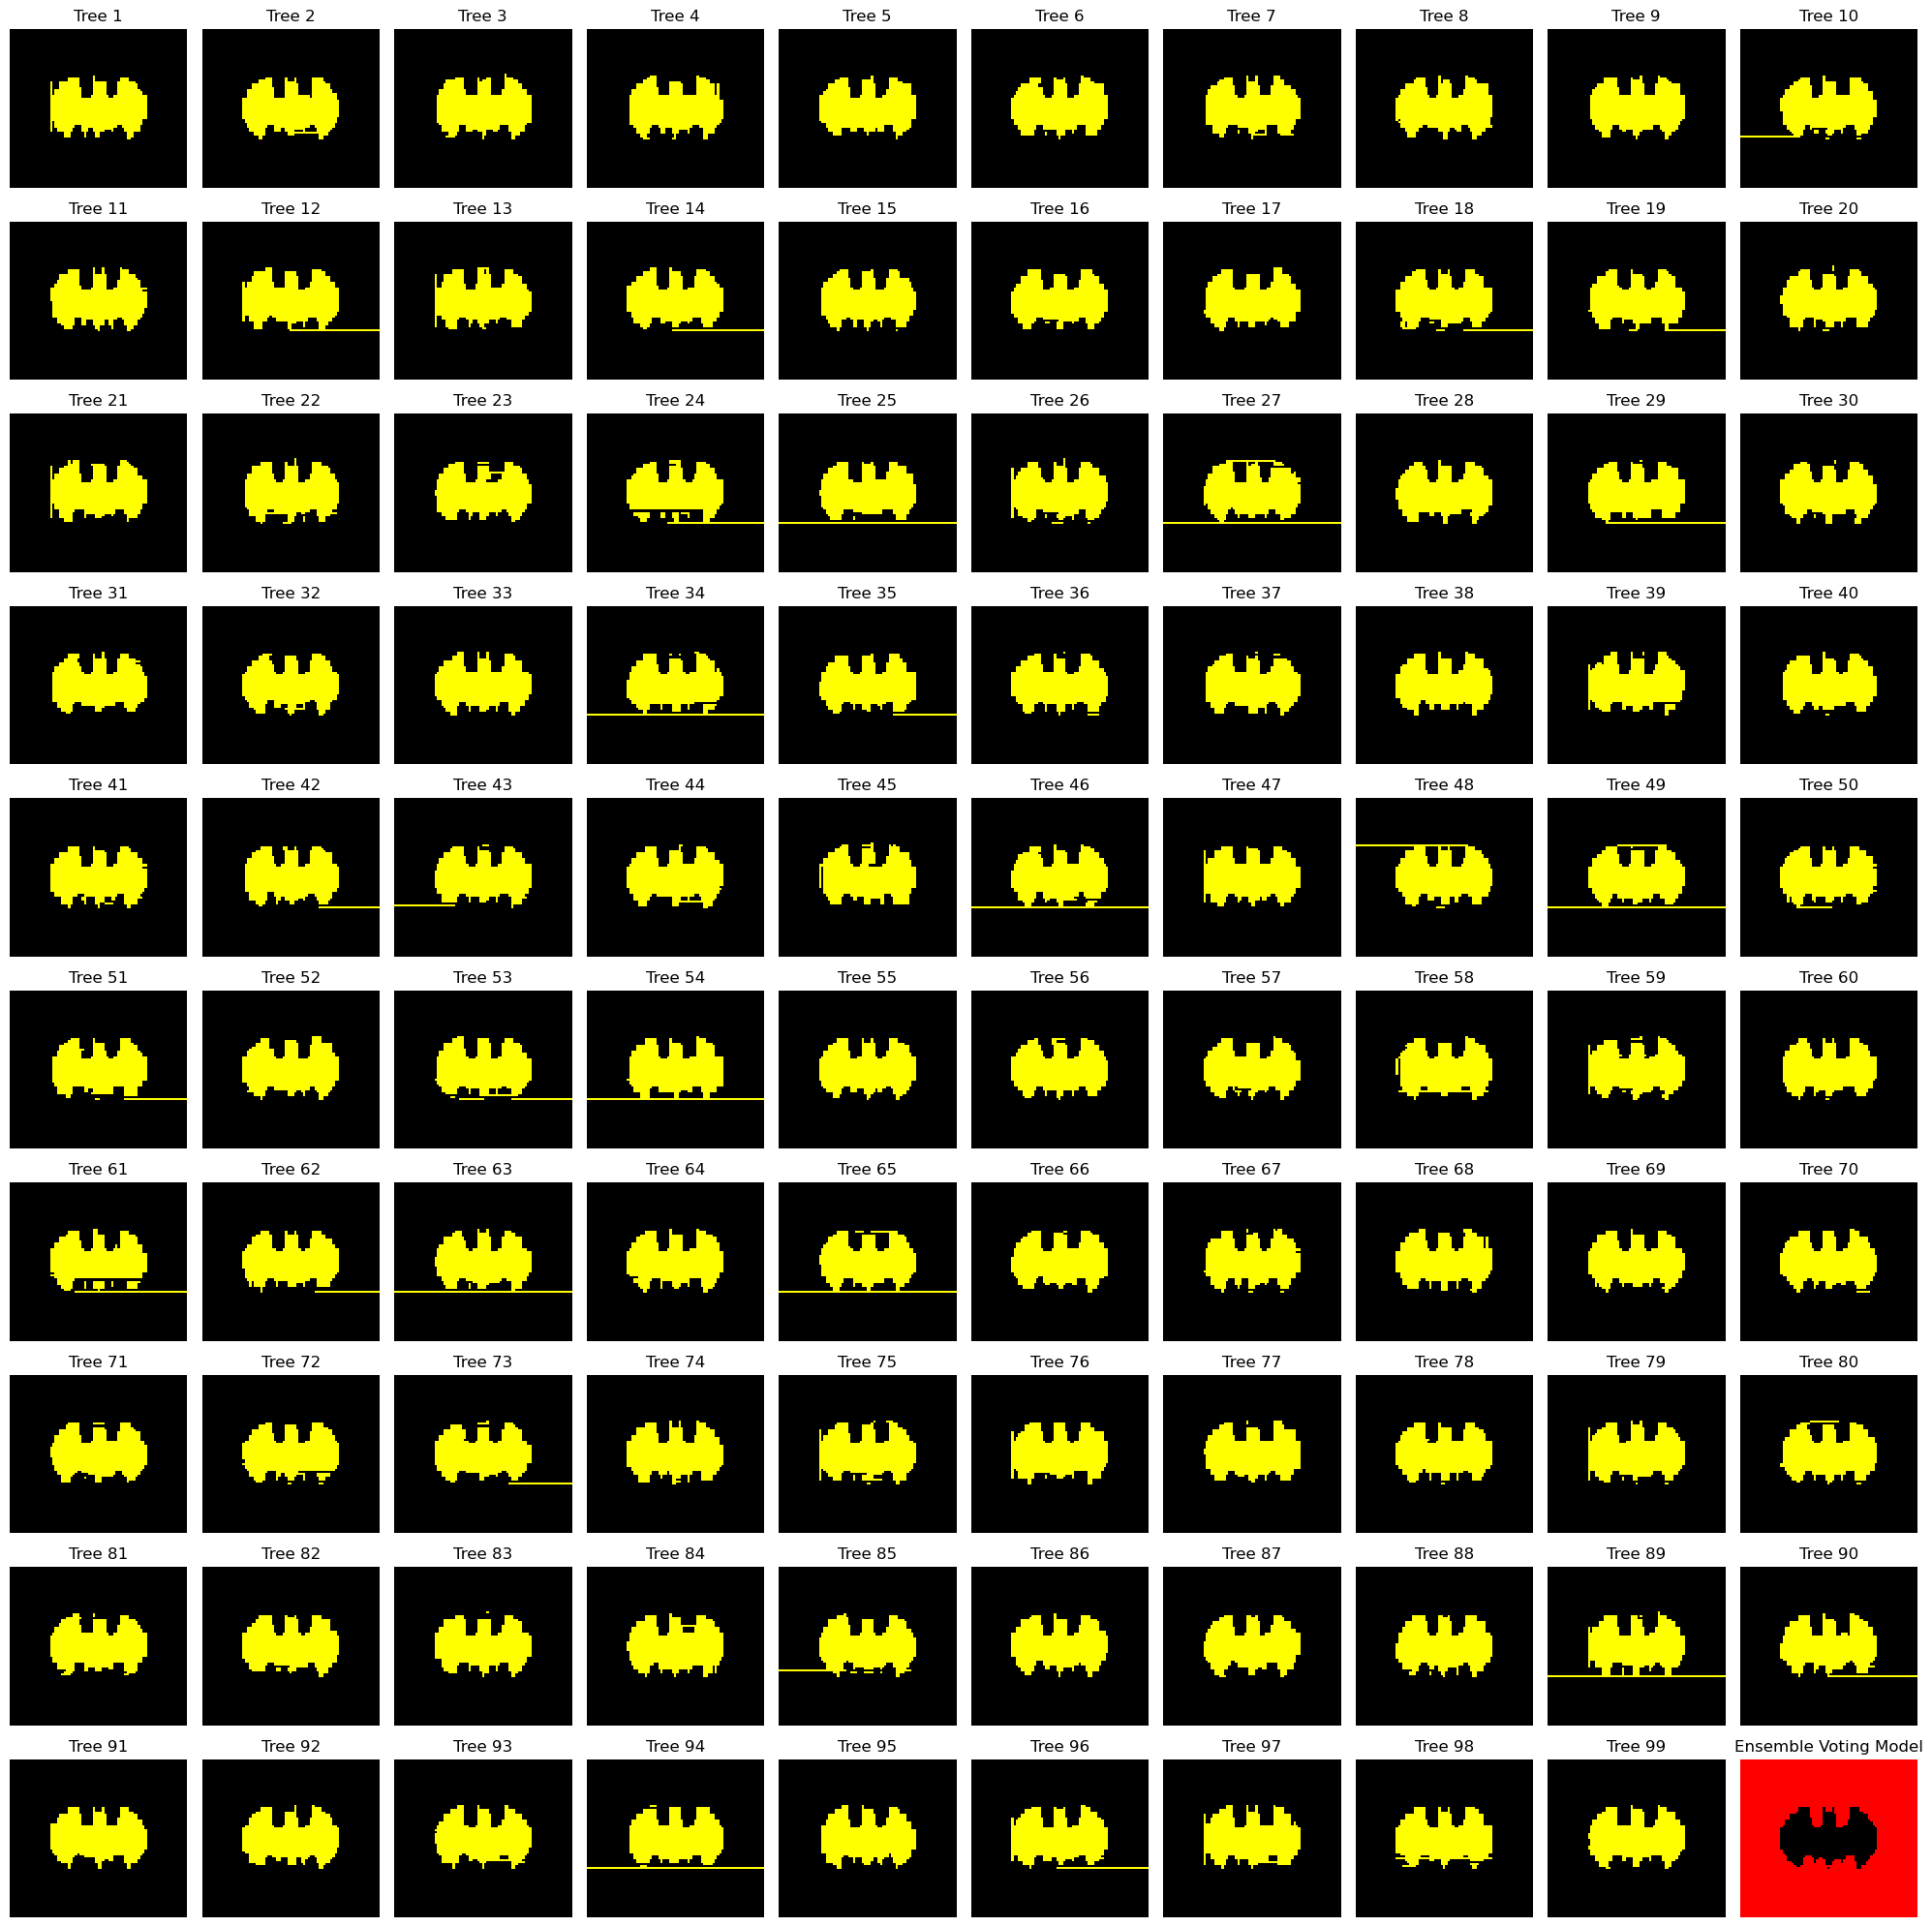

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# These are the batman inspired colormaps used when plotting the decision boundaries
cmap_individual_trees = ListedColormap(['#000000', '#FFFF00'])
cmap_ensemble_vote = ListedColormap(['#FF0000', '#000000'])  

# Function to plot decision boundary for a single tree
# The code is basically reused from my assignment 2.
def plot_tree_decision_boundary(ax, tree, X_train, color_map):
    # Generate grid points
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.07), np.arange(y_min, y_max, 0.07))

    # Predict labels for grid points
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundaries
    ax.pcolormesh(xx, yy, Z, cmap=color_map)

    ax.axis('off')

# Function to plot decision boundary for the ensemble voting model.
# Instead of predicting the gridpoints with one single model, this
# function takes the majority vote from each tree, which effectively becomes
# the ensemble vote tree (:
def plot_ensemble_decision_boundary(ax, decision_trees, X_train, color_map):
    # Generate grid points
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.07), np.arange(y_min, y_max, 0.07))

    # Generate predictions for each point on the grid using ensemble voting
    ensemble_predictions_grid = []
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    for point in grid_points:
        predictions = [tree.predict([point])[0] for tree in decision_trees]
        majority_vote = max({0, 1}, key=predictions.count)
        ensemble_predictions_grid.append(majority_vote)

    # Reshape predictions to match grid shape
    Z_ensemble = np.array(ensemble_predictions_grid).reshape(xx.shape)

    # Plot decision boundaries
    ax.pcolormesh(xx, yy, Z_ensemble, cmap=color_map)
    ax.axis('off')

# Create subplots for individual trees
num_trees = len(decision_trees)
num_rows = 10
num_cols = 10
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

for i, ax in enumerate(axs.flat):
    if i < num_trees - 1:
        plot_tree_decision_boundary(ax, decision_trees[i], X_train, cmap_individual_trees)
        ax.set_title(f'Tree {i+1}')
    elif i == num_trees - 1:
        plot_ensemble_decision_boundary(ax, decision_trees, X_train, cmap_ensemble_vote)
        ax.set_title('Ensemble Voting Model')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


#### d) Finally, a short comment on the results. Was it expected? Surprising? Do you see any benefits, downsides with this method?

The result was expected as in it fits what has been described during the lecture and in the course literature. The combined wisdom of the forest is indeed better than the sole tree. In my last recorded attempt the result went from 96.07% which is the mean value for the trees accuracy, to 97.3% which is the combined accuracy of the ensemble. It is an improvement, simply put, if the goal is to create the most accurate prediction model no matter the cost, then this method seems to be a solid choice.

However if we take the extra computational power needed to create the forest into account the improvement might not be worth it. In more complex datasets with more samples and features it would be a considerable amount of computations needed when creating a forest.